# ARIMAX

## Preparations

In [ ]:
# Handling data
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import plotly.express as px

# Stationarity tests
from statsmodels.tsa.stattools import adfuller, kpss

# Autocorr test
from statsmodels.stats.diagnostic import acorr_ljungbox

# Autocorrelation analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ARIMA models
from statsmodels.tsa.arima.model import ARIMA

# Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL, MSTL

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install pmdarima

# auto ARIMA
import pmdarima as pm
from pmdarima import auto_arima

In [ ]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Stocks data

We'll still be analyzing closing stocks prices. Get data from [here](https://www.nasdaq.com/market-activity/stocks/msft/historical?page=1&rows_per_page=10&timeline=y5).

Let's consider Microsoft  - 5 years of data. So, we have 1258 observations from 2019-11-18 up to 2024-11-15.

In [ ]:
stocks = pd.read_csv('microsoft.csv', parse_dates=['Date'])

In [ ]:
stocks.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-11-15,$415.00,28247640,$419.82,$422.80,$413.64
1,2024-11-14,$426.89,30246880,$425.00,$428.17,$420.00
2,2024-11-13,$425.20,21502190,$421.64,$429.325,$418.21
3,2024-11-12,$423.03,19401200,$418.25,$424.44,$417.20
4,2024-11-11,$418.01,24503320,$422.515,$424.81,$416.00


Here's some simple preprocessing.

In [ ]:
stocks.rename(columns={'Date':'ds', 'Close/Last':'y'}, inplace=True)
stocks['y'] = stocks['y'].apply(lambda x: x[1:]).astype(float)

stocks = stocks[['ds','y']].sort_values(by='ds').set_index('ds')

In [ ]:
stocks.head()

,y
ds,
2019-11-18,150.34
2019-11-19,150.39
2019-11-20,149.62
2019-11-21,149.48
2019-11-22,149.59


Let's remember how our data looks like.

In [ ]:
fig = px.line(stocks, x=stocks.index, y=stocks['y'],
              title="Microsoft closing prices (daily)")

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Today we'll be making out-of-sample forecasts, so let's split our data for train/test samples.

In [ ]:
train_size = int(len(stocks) * 0.85)
train, test = stocks[:train_size], stocks[train_size:]

In [ ]:
fig = px.line(title="Microsoft closing prices (daily)")
fig.add_scatter(x=train.index, y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

During lessons 5-6 we've started to discuss regressors or predictors, which can adjust our forecasts based on some external factors. Let's start by revising and then we'll move on forecasting models, which work with regressors.

## Predictors

### Dummy regressors

🐎 **What are dummy regressors?**

**Dummy regressors** for time series are used in time series analysis to model the effects of special events that influence the series, such as specific time periods, holidays, special events, or changes in policy. Dummy regressors mark periods of special event with 1 and everyting other - with 0.

The main advantage of dummy variables is that they can be easily modeled into the future (e.g. for your New Year dummy regressor, you can mark all the following New Years for your out-of-sample forecasts).

For our stocks data we'll consider 2 dummy regressors, which should have affected the prices seriously.

**US-China Trade War (2018 - 2020)**

* Start Date: July 6, 2018, when the US imposed tariffs on $34 billion worth of Chinese goods.

* End Date: January 15, 2020, when the Phase One trade deal was signed between the US and China.

**COVID-19 Pandemic (2020 - Present)**
* Start Date: January 2020, when the World Health Organization declared a public health emergency.
* Ongoing Impact: Though the pandemic officially began in 2020, its economic repercussions have continued well beyond 2020, with many countries still dealing with its effects as of 2024.

Further, let's create a dummy regressor for Trade war.

In [ ]:
date_range = pd.date_range(start=stocks.index.min(), end=stocks.index.max())

# Create the DataFrame
regressors = pd.DataFrame(date_range, columns=["ds"])

regressors

,ds
0,2019-11-18
1,2019-11-19
2,2019-11-20
3,2019-11-21
4,2019-11-22
...,...
1820,2024-11-11
1821,2024-11-12
1822,2024-11-13
1823,2024-11-14


In [ ]:
# US-China trade war period
trade_war_start = "2018-07-06"
trade_war_end = "2020-01-15"

# Mark the trade war dates with 1 and other dates with 0
regressors['trade_war'] = ((regressors['ds'] >= trade_war_start) \
                            & (regressors['ds'] <= trade_war_end)).astype(int)

regressors = regressors[~regressors['ds'].dt.weekday.isin([5, 6])] # remove weekends
regressors.set_index('ds', inplace=True)

regressors = regressors.join(stocks).dropna()['trade_war'] # there're several nulls in stocks
regressors = pd.DataFrame(regressors)

regressors

,trade_war
ds,
2019-11-18,1
2019-11-19,1
2019-11-20,1
2019-11-21,1
2019-11-22,1
...,...
2024-11-11,0
2024-11-12,0
2024-11-13,0


Remember, that for out-of-sample forecasts we should provide out-of-sample regressors. Let's see what it will look like.

In [ ]:
fig = px.line(title="Trade war dummy regressor")
fig.add_scatter(x=regressors[:train_size].index, y=regressors[:train_size]['trade_war'], mode='lines', name='Trade war for train', line=dict(color='blue'))
fig.add_scatter(x=regressors[train_size:].index, y=regressors[train_size:]['trade_war'], mode='lines', name='Trade war for forecast', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=400)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

Let's now create the same regressor fo COVID-19: COVID started in 2020 and officially has eneded on May 5 2023. Let's consider this period: 2020-01-01 - 2023-05-05.

Let's also consider a less agressive post-COVID effect separately: 2023-05-05 - 2025-05-05 (we presume that the effects will be seen for 2 years).

In [ ]:
# COVID periods
covid_start = "2020-01-01"
covid_end = "2023-05-05"
post_covid_end = "2025-05-05"

# Mark the COVID and post-COVID dates with 1 and other dates with 0
regressors['covid'] = ((regressors.index >= covid_start) \
                            & (regressors.index <= covid_end)).astype(int)
regressors['post_covid'] = ((regressors.index >= covid_end) \
                            & (regressors.index <= post_covid_end)).astype(int)

regressors = regressors[~regressors.index.weekday.isin([5, 6])] # remove weekends

regressors = regressors.join(stocks).dropna()[['trade_war', 'covid', 'post_covid']] # there're several nulls in stocks
regressors = pd.DataFrame(regressors)

regressors

,trade_war,covid,post_covid
ds,,,
2019-11-18,1,0,0
2019-11-19,1,0,0
2019-11-20,1,0,0
2019-11-21,1,0,0
2019-11-22,1,0,0
...,...,...,...
2024-11-11,0,0,1
2024-11-12,0,0,1
2024-11-13,0,0,1


Let's plot and see, what it looks like.

In [ ]:
fig = px.line(title="COVID-19 dummy regressor")
fig.add_scatter(x=regressors[:train_size].index, y=regressors[:train_size]['covid'], mode='lines', name='COVID for train', line=dict(color='blue'))
fig.add_scatter(x=regressors[train_size:].index, y=regressors[train_size:]['covid'], mode='lines', name='COVID for forecast', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=400)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [ ]:
fig = px.line(title="Post-COVID-19 dummy regressor")
fig.add_scatter(x=regressors[:train_size].index, y=regressors[:train_size]['post_covid'], mode='lines', name='post-COVID for train', line=dict(color='blue'))
fig.add_scatter(x=regressors[train_size:].index, y=regressors[train_size:]['post_covid'], mode='lines', name='post-COVID for forecast', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=400)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

### Continuous regressors

**Continuous regressors** are independent variables in a regression model that take continuous numerical values. Unlike dummy variabless, continuous regressors represent measurements or quantities that can take any value within a range. For example, these could be economic indicators, temperature, advertising spend, or any other external time-varying factors.

Let's download the whole dataset with all the info about Microsoft stocks.

In [ ]:
stocks_new = pd.read_csv('microsoft.csv', parse_dates=['Date'])
stocks_new.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-11-15,$415.00,28247640,$419.82,$422.80,$413.64
1,2024-11-14,$426.89,30246880,$425.00,$428.17,$420.00
2,2024-11-13,$425.20,21502190,$421.64,$429.325,$418.21
3,2024-11-12,$423.03,19401200,$418.25,$424.44,$417.20
4,2024-11-11,$418.01,24503320,$422.515,$424.81,$416.00


Let's consider open prices as a continous numeric predictor. Obviously, in real life tasks we'll rarely have regressors which can describe variable perfectly.

In [ ]:
stocks_new.rename(columns={'Date':'ds', 'Close/Last':'y', 'Open':'x'}, inplace=True)
stocks_new['y'] = stocks_new['y'].apply(lambda x: x[1:]).astype(float)
stocks_new['x'] = stocks_new['x'].apply(lambda x: x[1:]).astype(float)

stocks_new = stocks_new[['ds','y', 'x']].sort_values(by='ds').set_index('ds')

In [ ]:
fig = px.line(title="Microsoft closing and open prices (daily)")
fig.add_scatter(x=stocks_new.index, y=stocks_new['y'], mode='lines', name='closing price', line=dict(color='blue'))
fig.add_scatter(x=stocks_new.index, y=stocks_new['x'], mode='lines', name='open price', line=dict(color='red'))

fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

## ARIMAX model

**Formula**

$y_{t} = \alpha_{0} + \alpha_{1}y'_{t-1} + ... + \alpha_{p}y'_{t-p} + \beta_{1}\epsilon_{t-1} + ... + \beta_{q}\epsilon_{t-q} + \gamma_1*x_{1,t} + ... + \gamma_r*x_{r,t} + \epsilon_{t}$, where $\epsilon_{t}$ - white noise, $y'_t$ - differenced series, $x_{r,t}$ - predictor.

The ARIMAX model extends ARIMA by including external regressors (also called exogenous variables) that are assumed to influence the dependent time series.
 **X** in ARIMAX represents exogenous variables — additional variables that affect the target time series but are not themselves influenced by the target variable. These could be economic indicators, weather data, social events or any other external factors that might have an impact on the dependent variable.

Let's forecast our time series with ARIMAX and compare models with and without regressors.

In [ ]:
forecast_size = len(stocks) - train_size

forecast_size

189

### ARIMAX with dummy regressors

🐎 **What (p,d,q) orders have been chosen for ARIMA (no regressors)?**

In [ ]:
# Fit Auto ARIMA model
model = auto_arima(train, stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())

# Make a forecast for the next periods
forecast_auto_arima = model.predict(n_periods=forecast_size)


forecast_auto_arima = pd.DataFrame(forecast_auto_arima)
forecast_auto_arima['ds'] = test.index
forecast_auto_arima.set_index('ds', inplace=True)
forecast_auto_arima.columns = ['y_hat']

display(forecast_auto_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6368.603, Time=5.94 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6374.295, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6364.557, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6363.825, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6374.935, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6364.941, Time=1.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6365.127, Time=2.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6366.930, Time=5.68 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6365.201, Time=0.73 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 16.968 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1069
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3178.913
Date:                Sun, 08 Dec 2024   AIC     

,y_hat
ds,
2024-02-20,404.639293
2024-02-21,404.877202
2024-02-22,405.115110
2024-02-23,405.353018
2024-02-26,405.590927
...,...
2024-11-11,448.414433
2024-11-12,448.652341
2024-11-13,448.890249


🐎 **What (p,d,q) orders have been chosen for ARIMAX (with regressors)?**

In [ ]:
# Fit Auto ARIMA model
model = auto_arima(train, X=regressors[['trade_war', 'covid', 'post_covid']][:train_size], stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())

# Make a forecast for the next periods
forecast_reg_1 = model.predict(n_periods=forecast_size, X=regressors[['trade_war', 'covid', 'post_covid']][train_size:])

forecast_reg_1 = pd.DataFrame(forecast_reg_1)
forecast_reg_1['ds'] = test.index
forecast_reg_1.set_index('ds', inplace=True)
forecast_reg_1.columns = ['y_hat']
display(forecast_reg_1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6372.688, Time=14.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6378.335, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6368.588, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6367.896, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6378.811, Time=1.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6369.074, Time=2.62 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6369.271, Time=3.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6371.047, Time=2.27 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=6369.062, Time=0.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 26.242 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1069
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3177.948
Date:                Sun, 08 Dec 2024   AIC    

,y_hat
ds,
2024-02-20,404.629586
2024-02-21,404.859784
2024-02-22,405.089983
2024-02-23,405.320181
2024-02-26,405.550380
...,...
2024-11-11,446.986117
2024-11-12,447.216316
2024-11-13,447.446514


Let's see our forecasts and analyze them.

In [ ]:
fig = px.line(title="Microsoft closing prices (daily)")
fig.add_scatter(x=train.index, y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_auto_arima.index, y=forecast_auto_arima['y_hat'], mode='lines', name='forecast_no_regs', line=dict(color='red'))
fig.add_scatter(x=forecast_reg_1.index, y=forecast_reg_1['y_hat'], mode='lines', name='forecast_with_regs', line=dict(color='orange'))


fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

🐎 **What can you say about the impact of dummy regressors on forecasts?**

Dumy regressors haven't really impacted our forecasts. It's quite usual for ARIMAX models, although sometimes dummy regressors may change the behaviour of your time series drastically.

### Analyzing residuals

During lessons 5-6 we've discussed that it's import to analyze residuals of the model.

🐎 **What are residuals of the model? How should residuals behave in the perfect case?**

Residuals of the model: $e_t = y_t - \hat{y_t}$

In the best case: residuals are not autocorrelated and have zero mean.

The `model.plot_diagnostics()` method provides a set of diagnostic plots to analyze residuals and, thus, evaluate how well the fitted ARIMA model matches the data. These plots help identify potential issues with residuals, model fit, and assumptions. Here's an explanation of each plot it generates:

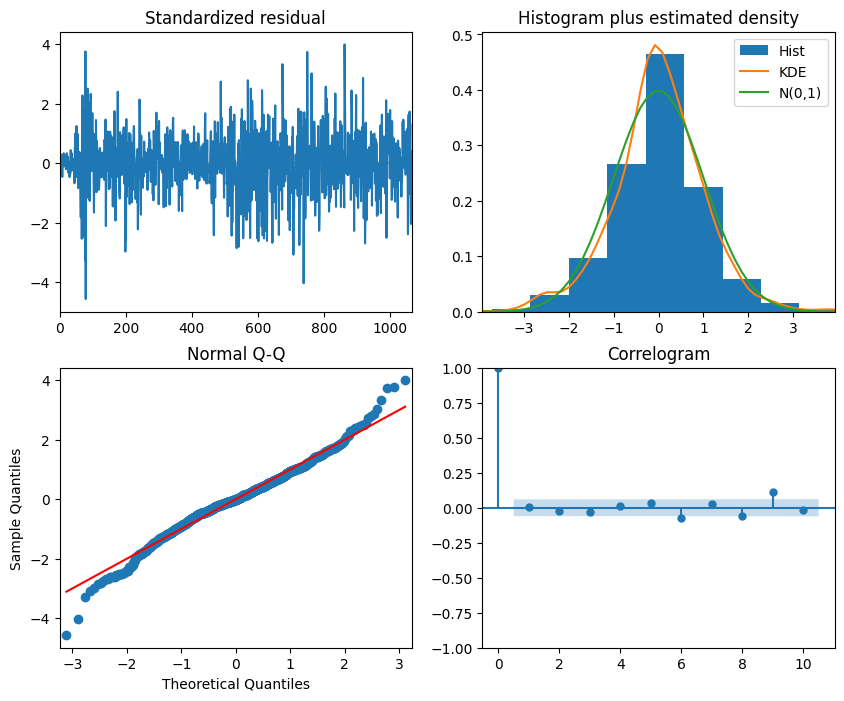

In [ ]:
fig = model.plot_diagnostics(figsize=(10,8))

Let's look into this plot precisely.

**Standardized Residuals Plot** - top left

Displays the residuals (errors) of the fitted model over time scaled by their standard deviation, which makes them easier to interpret and compare.

For $e_t = y_t - \hat{y_t}$:

$Standardized\_e_t = \frac{e_t}{σ^2}$

*Why should we standardize residuals?*

* Raw residuals depend on the scale of the data. For example, residuals from sales forecasts in millions will have much larger values than those from temperature data. Standardization removes this dependency by converting residuals into dimensionless units, making them comparable across datasets and easier to interpret.

* Standardized residuals make anomalies easy to spot because they provide a consistent way to measure how far off a prediction is, regardless of the scale of your data. Residuals beyond ±3 are red flags that deserve further investigation. These anomalies may show where the model performed poorly or where unusual events occurred in the data.

*What to look for?*

* Should look random with no obvious patterns:
  * The residuals should ideally behave like white noise—randomly distributed around zero, with no obvious patterns or trends.
  * Large deviations from zero may indicate the model isn’t capturing all patterns in the data.

*In our case*

Residuals look ok.

**Histogram plus estimated density** - top right

Displays a histogram of the residuals with a kernel density estimate (KDE) overlay, compared to a normal distribution curve.

* Histogram:
  * Displays the frequency of residuals in bins (intervals).
  * Helps identify the overall shape of the residual distribution (e.g., normal, skewed, multimodal).

* KDE (Kernel Density Estimate):

  * A smooth curve that represents the estimated probability density of residuals.
  * Provides a continuous approximation of the histogram to highlight patterns that may not be obvious from the bars.

*Why normality?*

Many models (e.g., ARIMA) assume residuals follow a normal distribution.

*What to look for?*

* Residuals should resemble a normal distribution (bell curve).
* Significant skewness or heavy tails suggests the model might not fully explain the data, or a transformation of the target variable may be needed.


*In our case*

The model might be overfitting certain parts of the data, leading to small residuals in some regions and large residuals in others

**Normal Q-Q Plot** - bottom left

Displayss a graphical tool used to assess if a set of data (in this case, residuals) follows a normal distribution. The plot compares the quantiles (percentiles) of the sample data against the quantiles of a theoretical normal distribution.

A *quantile* is a value that divides the data into intervals of equal probability. For example, the 50th quantile is the median, the 25th and 75th quantiles represent the first and third quartiles, etc. The plot takes the quantiles of the residuals and plots them against the quantiles of a standard normal distribution (mean = 0, variance = 1).

*What to look for?*

* If the residuals are normally distributed, the points will lie approximately along a straight line (usually the 45-degree line).
* Deviations from this line indicate departures from normality (e.g., skewness, or outliers).

*In our case*

There are curves or deviations at the ends of the Q-Q plot (both the upper and lower tails), it suggests that our data may have fat tails (kurtosis) or more extreme values than a normal distribution would predict.



**Correlogram** - bottom right

The autocorrelation function (ACF) of the residuals, showing how correlated residuals are at different lags.

ACF has been discussed during previous lessons.

### ARIMAX with continuous regressors

Now, let's see, how ARIMA performs with continuous regressors.

In [ ]:
# Fit Auto ARIMA model
model = auto_arima(train, X=stocks_new[['x']][:train_size], stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())

# Make a forecast for the next periods
forecast_reg_cont = model.predict(n_periods=forecast_size, X=stocks_new[['x']][train_size:])

print(forecast_reg_cont)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5892.189, Time=1.76 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5900.080, Time=0.64 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5892.270, Time=0.77 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5892.407, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5899.739, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=5892.707, Time=0.70 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5891.039, Time=5.65 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5889.286, Time=1.81 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=5891.489, Time=1.17 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5892.293, Time=1.26 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5887.999, Time=1.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5890.595, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5891.772, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5892.590, Time=0.69 sec
 ARIMA(1,0,2)(0,0,0)[0]          

In [ ]:
forecast_reg_cont = pd.DataFrame(forecast_reg_cont)
forecast_reg_cont['ds'] = test.index
forecast_reg_cont.set_index('ds', inplace=True)
forecast_reg_cont.columns = ['y_hat']

forecast_reg_cont

,y_hat
ds,
2024-02-20,403.878492
2024-02-21,400.555303
2024-02-22,410.457812
2024-02-23,415.881520
2024-02-26,411.636836
...,...
2024-11-11,422.674967
2024-11-12,418.408353
2024-11-13,421.799636


In [ ]:
fig = px.line(title="Microsoft closing prices (daily)")
fig.add_scatter(x=train.index, y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast_auto_arima.index, y=forecast_auto_arima['y_hat'], mode='lines', name='forecast_no_regs', line=dict(color='red'))
fig.add_scatter(x=forecast_reg_1.index, y=forecast_reg_1['y_hat'], mode='lines', name='forecast_with_dummy_regs', line=dict(color='orange'))
fig.add_scatter(x=forecast_reg_cont.index, y=forecast_reg_cont['y_hat'], mode='lines', name='forecast_with_continuous_regs', line=dict(color='hotpink'))


fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

🐎 **What can you say about the impact of dummy regressors on forecasts?**

Continuous regressors have improved our forecasts significantly, but it's obviously because open prices are very similar to closing prices. Such regressors are almost impossible to find in real life.

🐎 **What continuous regressors might be useful for stocks prices?**

One of such regressors might be net income of the company. Info about net income of Microsoft can be retrieved from the [source](https://www.macrotrends.net/stocks/charts/MSFT/microsoft/net-income).

🐎 Task for 20 minutes

**Predict stocks with Auto-ARIMAX with regressors.**

**1. Predict stocks with Auto-ARIMAX with dummy regressors for Trade war, COVID-19 and post-COVID.**

Do not include open prices!!!

**2. Perform out-of-sample forecasts with Auto-ARIMAX with continous regressor - Microsoft net income per quarter.** Think, how to treat different frequency regressors for the time series?

Find Microsoft net income per quarter in [microsoft_net_income.csv](https://drive.google.com/file/d/1ZXq0VetcQFLEQVu4tRr6O182Xi5-tC82/view?usp=sharing).


In [ ]:
net_income = pd.read_csv('microsoft_net_income.csv', sep=';', parse_dates=['quarter'])
net_income.rename(columns={'quarter':'ds', 'net_income (Millions of US $)':'x'}, inplace=True)
net_income['x'] = net_income['x'].apply(lambda x: x[1:].replace(',','')).astype(float)
net_income = net_income[['ds','x']].sort_values(by='ds').set_index('ds')
net_income

,x
ds,
2009-03-31,2977.0
2009-06-30,3045.0
2009-09-30,3574.0
2009-12-31,6662.0
2010-03-31,4006.0
...,...
2023-09-30,22291.0
2023-12-31,21870.0
2024-03-31,21939.0


## How to choose regressors?

**What problems can happen if we include irrelevant regressors or too many regressors to ARIMA-like models?**

Including irrelevant regressors in an ARIMAX model (or any regression-based model) can lead to several issues that negatively impact the model's performance and reliability. Similar things happen to the model with too many regressors included.

Here are the main reasons why:

1. **Overfitting**
  
  Including irrelevant regressors increases the complexity of the model, which may lead to overfitting.

  At the same time, the more regressors you include, the more likely the model is to fit the noise in the data, rather than the actual underlying relationships.

2. **Increased variance in predictions**
  
  When you add irrelevant predictors, the variance of the estimated coefficients can increase. This is because the model tries to "explain" the noise introduced by unnecessary variables. As a result, the predictions become more sensitive to small changes in the input data, making the model less robust and more prone to fluctuation.

  Many regressors may lead to overfitting and higher variance in predictions.

3. **Multicollinearity**

  Multicollinearity arises when two or more independent variables (regressors) are highly correlated with each other. If regressors are correlated with each other or with other relevant/irrelevant predictors, it can lead to multicollinearity. This issue makes it difficult to interpret the individual impact of each regressor since changes in one regressor might be reflected in changes in another.

4. **Reduced interpretability**

  One of the key advantages of using a model like ARIMAX is its interpretability. You want to understand how the exogenous variables (regressors) influence the dependent variable.
  
  Including irrelevant variables makes the interpretation more complex and can lead to misleading conclusions about the relationships between the variables. On the other hand, as the number of regressors increases, the interpretability of the model decreases.

5. **Wasted computational resources**

  Training a model with irrelevant or too many regressors requires more data processing and computation, especially if the dataset is large. This increases the training time and computational burden without providing any real benefit in terms of model accuracy.

6. **Potential bias**

  In some cases, including irrelevant regressors can introduce bias in the estimation of the model's parameters, particularly if the regressors are correlated with other predictors or if there is omitted variable bias.

  Adding more predictors increases the variance of the model, making it more sensitive to fluctuations in the data. While this can improve fit on the training data (lower bias), it simultaneously increases the risk of overfitting (higher variance). This leads to a poor bias-variance tradeoff, where the model becomes too complex, trying to fit the noise in the training data at the cost of generalizability.

Selecting the right regressors is critical to the model's accuracy and interpretability.

**How to select regressors?**

* **Common sense**:
  
  * Choose variables with a logical relationship to your target variable
  * Consider domain expertise and previous research
  * Think about the causal mechanism behind the relationship

* **Using the graph**:
  * Plot your target variable and a regressor against each other

We've discussed that net income is a logical regressor in case of stocks prices.
So, let's plot the graph and see net income compared to the stocks prices.

In [ ]:
net_income

,x
ds,
2009-03-31,2977.0
2009-06-30,3045.0
2009-09-30,3574.0
2009-12-31,6662.0
2010-03-31,4006.0
...,...
2023-09-30,22291.0
2023-12-31,21870.0
2024-03-31,21939.0


Net income regressors has quarterly frequency, but our target time series is daily.

🐎 **How would you transform regressor so that we can use it in ARIMAX?**

In [ ]:
date_range = pd.date_range(start=stocks.index.min(), end=stocks.index.max())

# Create the DataFrame
net_income_daily = pd.DataFrame(date_range, columns=["ds"])

net_income_daily = net_income_daily.set_index('ds').join(net_income, how='outer').fillna(method='ffill').loc[stocks.index.min():stocks.index.max()]

net_income_daily

,x
ds,
2019-11-18,10678.0
2019-11-19,10678.0
2019-11-20,10678.0
2019-11-21,10678.0
2019-11-22,10678.0
...,...
2024-11-11,24667.0
2024-11-12,24667.0
2024-11-13,24667.0


In [ ]:
fig = px.line(title="Microsoft closing prices (daily)")
fig.add_scatter(x=stocks.index, y=stocks['y'], mode='lines', name='y', line=dict(color='blue'))
fig.add_scatter(x=net_income_daily.index, y=net_income_daily['x'], mode='lines', name='net income', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=800, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In this case (and in most similar cases) we can use **dual Y-axis graphs**. A graph with two y-axes is used when you want to plot two sets of data that have different scales but are related to the same x-axis (typically time or some other common variable). In these graphs, one y-axis is placed on the left and the other on the right, allowing you to compare two different types of data simultaneously while maintaining readability.

Let's plot a dual y-axis graphs.

The obtained graph provides valuable insights into the relationship between target variable and the regressor.

In [ ]:
import plotly.graph_objects as go

# Create an empty fig
fig = go.Figure()

# Add y graph on the left
fig.add_trace(go.Scatter(
    x=stocks.index,
    y=stocks['y'],
    mode='lines',
    name='y',
    line=dict(color='blue'),
    yaxis='y1'  # Tie to y1
))

# Add x graph on the right
fig.add_trace(go.Scatter(
    x=net_income_daily.index,
    y=net_income_daily['x'],
    mode='lines',
    name='net income',
    line=dict(color='red'),
    yaxis='y2'  # Tie to y1
))


fig.update_layout(
    title="Microsoft closing prices (daily)",
    template='plotly_white',
    width=1000,
    height=500,
    yaxis=dict(
        title='stock prices',
    ),
    yaxis2=dict(
        title='net income',
        overlaying='y',  # Impose axes
        side='right'
    ),
    xaxis=dict(title='Date')
)

# Отображаем график
fig.show()

🐎 **Do you think net income is a useful continuous regressors for stocks prices?**

Yes, because net income is a great flag for increases and decreases in stock prices.

**How to select regressors?**

* **"En-masse"**:
  * Fit the ARIMA model including all the exogenous regressors and obtain the t-statistic for the significance of each regressor.
  * Remove those regressors for which the t-statistic is lower than a threshold chosen beforehand.
   * Fit again the ARIMA model with the selected regressors and check again the t-statistics removing those regressors that are not significant.
   * Repeat this process until all the regressors that were not discarded so far (if any) are significant.

Now let's consider significance from ARIMAX model.

In [ ]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1069
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2939.999
Date:                Sun, 08 Dec 2024   AIC                           5887.999
Time:                        15:09:56   BIC                           5907.897
Sample:                             0   HQIC                          5895.537
                               - 1069                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0004      0.000   3019.148      0.000       1.000       1.001
ar.L1          0.4812      0.163      2.950      0.003       0.161       0.801
ma.L1         -0.5881      0.150     -3.918      0.0

🐎 **Do you think net income is a useful continuous regressors for stocks prices?**

**How to select regressors?**


* **Correlations**: you might hear a lot about correlations, however, to understand this concept we have to dive into vector models. So, if you'd like to learn this, look for these terms: "cross-correlation", "causality", "vector autoregressions".

## Sum Up

- Discussed dummy regressors (1 - for special event, 0 - otherwise) and contionous regressors (e.g. net income, oil prices)
- Used ARIMAX models for forecasting with regressors
- Learned how we can choose proper regressors for the model

# SARIMAX

Forecasting seasonal time series is crucial because many real-world processes, such as sales, demand, and weather patterns, follow predictable cycles. By accurately forecasting these seasonal variations, businesses and organizations can optimize resources, improve planning, reduce costs, and better meet customer demand. Effective seasonal forecasting enables proactive decision-making, ensuring that entities can adapt to expected fluctuations and capitalize on recurring trends.

## Data

Further we will be predicting the unit sales for thousands of items sold at different "Favorita" stores located in Ecuador. The training data includes dates, store and item information, whether that item was being promoted, as well as the unit sales. Additional files include supplementary information that may be useful in building your models.

Data has been retrieved from [kaggle](https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data?select=train.csv.7z). You can download the dataset [here](https://drive.google.com/file/d/1xF5HXH0_fJlSr82A0nRehu6NVeq6mvhR/view?usp=sharing).

In [ ]:
# Data preparation

# df_train = pd.read_csv('train.csv', parse_dates=['date'])
# df_stores = pd.read_csv('stores.csv')
# df_item = pd.read_csv('items.csv')

# df_train = pd.merge(df_train, df_item, on='item_nbr',how='left')
# df_train = pd.merge(df_train, df_stores, on='store_nbr',how='left')

# df_full = pd.pivot_table(df_train, values='unit_sales', index=['date','city', 'state','type','family'],
#                aggfunc='sum').reset_index()

# df_full.to_csv('train_data.csv')

In [ ]:
sales_raw = pd.read_csv('train_data.csv', parse_dates=['date'])
sales_raw

,date,city,state,store_type,family,sales
0,2013-01-01,Salinas,Santa Elena,D,BEAUTY,2.000
1,2013-01-01,Salinas,Santa Elena,D,BEVERAGES,810.000
2,2013-01-01,Salinas,Santa Elena,D,BREAD/BAKERY,180.589
3,2013-01-01,Salinas,Santa Elena,D,CLEANING,186.000
4,2013-01-01,Salinas,Santa Elena,D,DAIRY,143.000
...,...,...,...,...,...,...
1363624,2017-08-15,Santo Domingo,Santo Domingo de los Tsachilas,D,PLAYERS AND ELECTRONICS,9.000
1363625,2017-08-15,Santo Domingo,Santo Domingo de los Tsachilas,D,POULTRY,241.011
1363626,2017-08-15,Santo Domingo,Santo Domingo de los Tsachilas,D,PREPARED FOODS,52.121
1363627,2017-08-15,Santo Domingo,Santo Domingo de los Tsachilas,D,PRODUCE,1357.823


We'll look into sales of the company in total. Let's prepare the dataset.

For this lesson we'll take only 2015-2017, although the dataset provides us with 2013-2017.

In [ ]:
sales = pd.pivot_table(sales_raw, index='date', values='sales', aggfunc='sum').reset_index()
sales.columns = ['ds', 'y']
sales = sales.set_index('ds')
sales = sales.loc['2015-01-01':]
sales

,y
ds,
2015-01-01,12773.617
2015-01-02,657763.392
2015-01-03,648880.687
2015-01-04,730923.776
2015-01-05,569267.298
...,...
2017-08-11,826373.722
2017-08-12,792630.535
2017-08-13,865639.677


Now let's plot the data.

In [ ]:
fig = px.line(sales, x=sales.index, y=sales['y'],
              title="Favorita sales")

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="sales")
fig.show()

Now let's split our data for train/test. We'll take 2017 year for test and 2015-2016 - for train.

In [ ]:
train_size = 365*2-1
train, test = sales[:train_size], sales[train_size:]

In [ ]:
fig = px.line(title="Sales")
fig.add_scatter(x=train.index, y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

🐎 **What can you say about this sales time series?**

Our data, by its nature, has a trend and some seasonalities (probably weekly, monthly and yearly).

🐎 **What should we do with time series with trend and seasonality?**

## Decomposition

Here we presume multiple seasonalities: weekly, monthly and yearly.

🐎 **What lengths of seasonal periods should we take?**

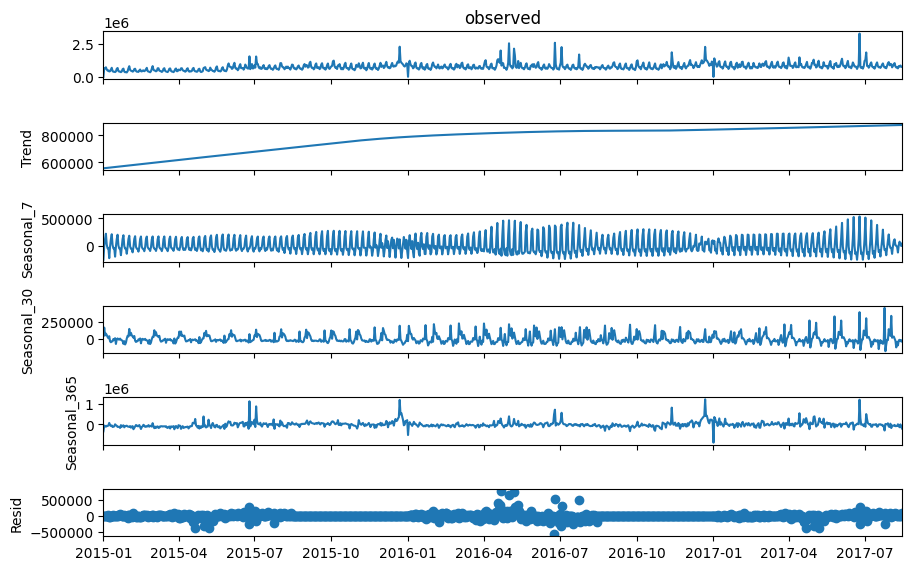

<Axes: xlabel='ds'>

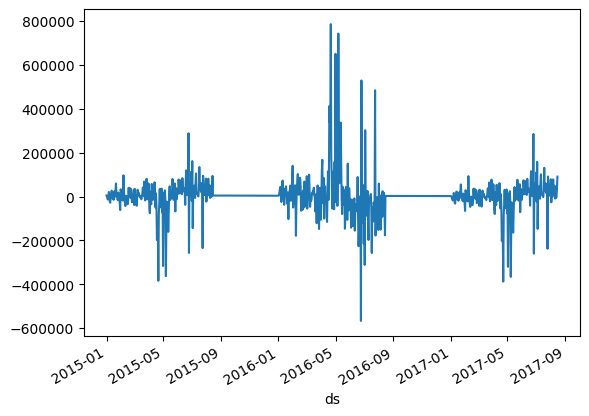

In [ ]:
mstl = MSTL(sales['y'],  periods=(7,30,365))
res = mstl.fit()

fig = res.plot()
fig.set_size_inches(10, 6)
plt.show()

res.resid.plot()

🐎 **How can we judge success of our decomposition?**

We should look into our residuals.

In [ ]:
acorr_ljungbox(res.resid, return_df=True)

,lb_stat,lb_pvalue
1,34.949369,3.383910e-09
2,98.678557,3.734423e-22
3,125.443879,5.185543e-27
4,168.812871,1.880362e-35
5,193.241178,7.923268e-40
6,256.517408,1.659083e-52
7,258.553533,4.182664e-52
8,303.815838,6.344885e-61
9,306.952372,8.741592e-61
10,361.171940,1.693196e-71


In [ ]:
adf_test(res.resid)

Results of Dickey-Fuller Test:
Test Statistic                  -4.020251
p-value                          0.001308
#Lags Used                      22.000000
Number of Observations Used    933.000000
Critical Value (1%)             -3.437378
Critical Value (5%)             -2.864643
Critical Value (10%)            -2.568422
dtype: float64


🐎 **What can you say about decomposition based on residuals?**

Unfortuntaly, for many real-life scenarios we may obtain autocorrelated residuals.

* **Seasonality and Trend Modeling Limitations**: Decomposition methods like STL or classical decomposition attempt to isolate trend and seasonality from the data, but in practice, they may not fully capture all the complexities of the time series. Some seasonality patterns or trends might be too subtle, or the model might miss certain cyclical or irregular variations. This results in residuals that still exhibit autocorrelation.

* **Interaction Between Trend and Seasonality**: In some cases, the seasonal and trend components might interact in complex ways that are not easily captured by simple additive or multiplicative models. For example, if seasonality changes over time (i.e., the seasonal amplitude or pattern varies), the decomposition might not fully account for this variability, leaving autocorrelated residuals.

* **Ommited variables**: If there are external factors (exogenous variables) that influence the time series but are not included in the decomposition (or in subsequent models), the residuals will reflect this missing information and may show autocorrelation. For instance, economic, weather, or marketing factors could influence sales patterns but are not captured in a simple decomposition.

## Forecasting trend

Models like auto-ARIMA may help us predict trends after decomposition (remember, that you've actually predicted trends during last lessons).

So, let's try to predict our trend.

In [ ]:
trend = res.trend.reset_index()
trend.columns = ['ds','y']
trend = trend.set_index('ds')
trend

,y
ds,
2015-01-01,556112.490160
2015-01-02,556796.629209
2015-01-03,557480.687471
2015-01-04,558164.664287
2015-01-05,558848.559010
...,...
2017-08-11,874311.532360
2017-08-12,874479.242530
2017-08-13,874647.153045


In [ ]:
trend_train, trend_test = trend[:train_size], trend[train_size:]

In [ ]:
fig = px.line(title="Sales")
fig.add_scatter(x=trend_train.index, y=trend_train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=trend_test.index, y=trend_test['y'], mode='lines', name='test', line=dict(color='green'))

fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

In [ ]:
forecast_size = len(sales) - train_size
forecast_size

227

In [ ]:
# Fit Auto ARIMA model
model = auto_arima(trend_train, stepwise=True, trace=True)

# Print the summary of the model
print(model.summary())

# Make a forecast for the next periods
trend_forecast = model.predict(n_periods=forecast_size)


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3894.936, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3992.099, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3970.476, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3975.806, Time=0.06 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3892.913, Time=0.37 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=3965.686, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3890.938, Time=0.23 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3892.913, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3955.767, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=3892.386, Time=0.64 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 2.338 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  729
Model:               SARIMAX(1, 2, 1)   Log Likelihood        

In [ ]:
trend_forecast = pd.DataFrame(trend_forecast)
trend_forecast['ds'] = trend_test.index
trend_forecast.set_index('ds', inplace=True)
trend_forecast.columns = ['y_hat']

trend_forecast

,y_hat
ds,
2017-01-01,840690.389641
2017-01-02,840828.335400
2017-01-03,840966.665887
2017-01-04,841105.376414
2017-01-05,841244.462352
...,...
2017-08-11,875904.010743
2017-08-12,876071.463600
2017-08-13,876238.941786


Let's see the obtained trend forecast.

In [ ]:
fig = px.line(title="Sales")
fig.add_scatter(x=trend_train.index, y=trend_train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=trend_test.index, y=trend_test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=trend_forecast.index, y=trend_forecast['y_hat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

## Forecasting seasonality

Seasonality can be forecasted in multiple ways. Today we'll be discussing SARIMAX models.

**SARIMA** stands for Seasonal Autoregressive Integrated Moving Average. It's an extension of the ARIMA model, but with additional components that help capture seasonal patterns in time series data. Let's break it down in simple terms.

Before we dive into SARIMA, let's quickly review ARIMA. **ARIMA** is a model that consists of three main parts:

* **AR (AutoRegressive) (p)**: It uses past values in the series to predict the future (lags).
* **I (Integrated) (d)**: It uses differencing to make the data stationary (removes trends).
* **MA (Moving Average) (q)**: It uses past forecast errors to improve predictions.
* **Seasonal components (P,D,Q)**: These are similar to the non-seasonal components but are applied to the seasonal component of the series.

SARIMA is similar to ARIMA, but it adds seasonal components. Here's how it works:

$$SARIMA(p,d,q)×(P,D,Q)_m​$$

* **p, d, q** — These are the regular ARIMA(p,d,q) parameters.
* **P, D, Q** represent the seasonal autoregressive order, degree of seasonal differencing, and seasonal moving average order, respectively.
* **m** represents the length of the seasonal period (e.g., 12 for monthly data with an annual cycle).

**Seasonal AR (P)**. It measures the relationship between an observation and a specific number of periods ago, but for the seasonal period (e.g., 12 months ago).

**Seasonal Differencing (D)**: If the data has seasonal patterns, it often helps to take the seasonal difference (subtracting data from the same period in the previous season). This helps remove seasonality and makes the data easier to model.

**Seasonal MA (Q)**: Similar to the regular MA part, this part uses the errors from the previous seasons to improve forecasts.

*Example:* Monthly Sales Data with Yearly Seasonality (m=12)

* **m = 12**: This mean that for monthly data with yearly seasonality (January to December).
* **P = 1**: This means we are using the past month's sales (from the same month in the previous year) to help predict the current month's sales.
* **D = 1**: This indicates we will perform seasonal differencing to remove trends and make the data stationary - $Y_t'​=Y_t​-Y_{t−s​}$.
* **Q = 1**: This means we will correct the forecast using errors from the previous seasonal period.

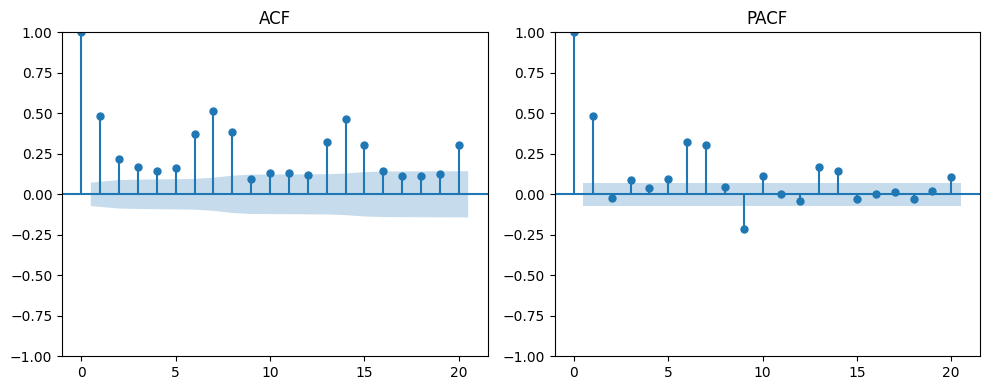

In [ ]:
# 2 graphs side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# ACF
plot_acf(train['y'].dropna(), ax=ax[0], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[0].set_title('ACF')

# PACF
plot_pacf(train['y'].dropna(), ax=ax[1], lags=20) # nans are only present in the first 3 and the last 3 observations
ax[1].set_title('PACF')


plt.tight_layout()
plt.show()

In [ ]:
sarima_model = auto_arima(train['y'],
                          seasonal=True,
                          m=7,  # weekly seasonality
                          max_p=3,
                          max_q=3,
                          trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True)
print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=19838.552, Time=2.14 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=20248.189, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=20105.917, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=20004.432, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=20246.213, Time=0.03 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=19930.176, Time=1.87 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=19908.056, Time=3.35 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=6.59 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=19970.184, Time=2.02 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=19909.378, Time=4.31 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=19872.087, Time=2.77 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=19849.570, Time=3.99 sec
 ARIMA(2,1,1)(1,0,1)[7] intercept   :

In [ ]:
forecast = sarima_model.predict(n_periods=forecast_size)

;;

In [ ]:
forecast = pd.DataFrame(forecast)
forecast['ds'] = test.index
forecast.set_index('ds', inplace=True)
forecast.columns = ['y_hat']

forecast

,y_hat
ds,
2017-01-01,1.180872e+06
2017-01-02,1.245032e+06
2017-01-03,1.025630e+06
2017-01-04,1.010644e+06
2017-01-05,9.963335e+05
...,...
2017-08-11,1.480506e+06
2017-08-12,1.477620e+06
2017-08-13,1.614177e+06


In [ ]:
fig = px.line(title="Sales")
fig.add_scatter(x=train.index, y=train['y'], mode='lines', name='train', line=dict(color='blue'))
fig.add_scatter(x=test.index, y=test['y'], mode='lines', name='test', line=dict(color='green'))
fig.add_scatter(x=forecast.index, y=forecast['y_hat'], mode='lines', name='forecast', line=dict(color='red'))


fig.update_layout(template='plotly_white', width=1000, height=500)
fig.update_xaxes(title_text="date")
fig.update_yaxes(title_text="closing price")
fig.show()

🐎 Task for 20 minutes

**Predict sales of Favorita with regressors.**

**1. Prepare dummy regressors for holidays.**

**2. Prepare continuous regressors for oil prices.**

**3. Forecast time series with SARIMAX with regressors - this time oil price and holidays.**
Find oil prices in [oil.csv](https://drive.google.com/file/d/1D4rnInuBSKsYkaQl5yi9DKpUuKtrwIAQ/view?usp=drive_link) and holidays in [holidays_events.csv](https://drive.google.com/file/d/1cWdWO8CevKUPU-vqU58MhGun6_Z8_9kA/view?usp=drive_link).


In [ ]:
oil = pd.read_csv('oil.csv', parse_dates=['date'])
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [ ]:
holidays = pd.read_csv('holidays_events.csv', parse_dates=['date'])
holidays

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


## Sum Up

- Performed MSTL decomposition and obtained trend and seasonalities components
- Forecasted trend with auto-ARIMAX model
- Discussed SARIMAX forecasting model which is useful for time series with seasonality

# Quality metrics

**Quality metrics** for time series forecasting are essential to quantitatively assess how accurate and effective a forecast is. They allow us to compare different models, select the most suitable one for a specific task, and identify weaknesses in the forecasting process.

## Scale-dependent errors

$$\text{ Mean absolute error: }  MAE = mean(|y_t - \hat{y_t}|)$$
$$\text{ Root mean squared error: }  RMSE = \sqrt{mean(y_t - \hat{y_t})^2}$$

It is important to note that **RMSE** aims to minimize the **mean distance** between actual and predicted points, while **MAE** focuses on the **median** distance.

Consequently, **RMSE penalizes large deviations** between actual and predicted values more heavily than MAE.



       Scenario  MAE      RMSE
0  Small Errors  1.0  1.000000
1       Outlier  4.8  8.988882


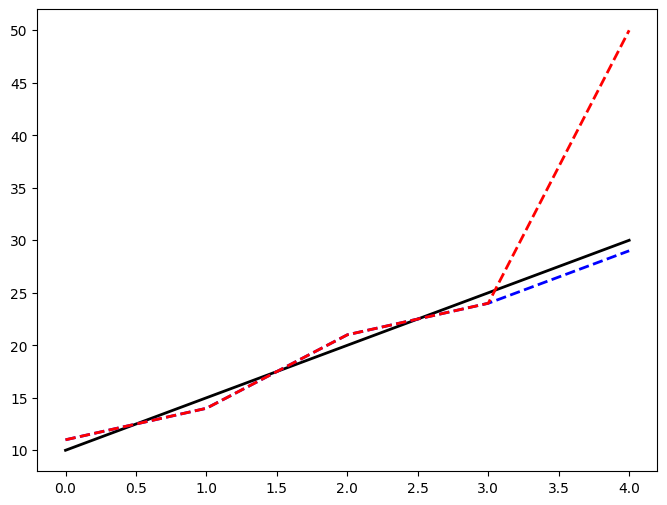

In [ ]:
# Actual values
y_actual = np.array([10, 15, 20, 25, 30])

# Predicted values: Scenario 1 - Small consistent errors
y_pred_small_errors = np.array([11, 14, 21, 24, 29])

# Predicted values: Scenario 2 - One large outlier error
y_pred_outlier = np.array([11, 14, 21, 24, 50])  # Outlier at the last value

# Calculate MAE and RMSE for small consistent errors
mae_small = np.mean(np.abs(y_actual - y_pred_small_errors))
rmse_small = np.sqrt(np.mean((y_actual - y_pred_small_errors) ** 2))

# Calculate MAE and RMSE for the outlier case
mae_outlier = np.mean(np.abs(y_actual - y_pred_outlier))
rmse_outlier = np.sqrt(np.mean((y_actual - y_pred_outlier) ** 2))

# Display results
results = pd.DataFrame({
    "Scenario": ["Small Errors", "Outlier"],
    "MAE": [mae_small, mae_outlier],
    "RMSE": [rmse_small, rmse_outlier]
})


plt.figure(figsize=(8, 6))

# Plot actual values
plt.plot(y_actual, label="Actual Values", color="black", linewidth=2)

# Plot predictions for small errors
plt.plot(y_pred_small_errors, label="Predicted (Small Errors)", linestyle="--", color="blue", linewidth=2)

# Plot predictions with outlier
plt.plot(y_pred_outlier, label="Predicted (With Outlier)",linestyle="--", color="red", linewidth=2)


print(results)

Let's look into errors for the forecast with no regressors.

In [ ]:
print('MAE: ', np.mean(np.abs(test['y']-forecast['y_hat'])))
print('RMSE: ', np.sqrt(np.mean((test['y']-forecast['y_hat'])**2)))

MAE:  459365.179650879
RMSE:  511988.9519288533


## Scale-independent errors

$$\text{ Mean absolute percentage error: }  MAPE = mean(\frac{|y_t - \hat{y_t}|}{y_t})$$

Despite its intuitive appeal, **MAPE** has two significant drawbacks:

* If the values of $y_t$ are close to zero, the error becomes significantly inflated or may not be computable at all.

* MAPE tends to be much higher when the forecast overestimates the actual metric (Forecast > Actual), as the denominator in MAPE is the actual value. This leads to a lower limit of 100% error when the forecast is above zero, while the upper bound is unbounded, meaning the error can approach infinity. Thus, MAPE is assymetric.



                     Scenario     MAPE (%)
0              Overestimation  1000.000000
1             Underestimation    50.000000
2  Underestimation (negative)   161.111111


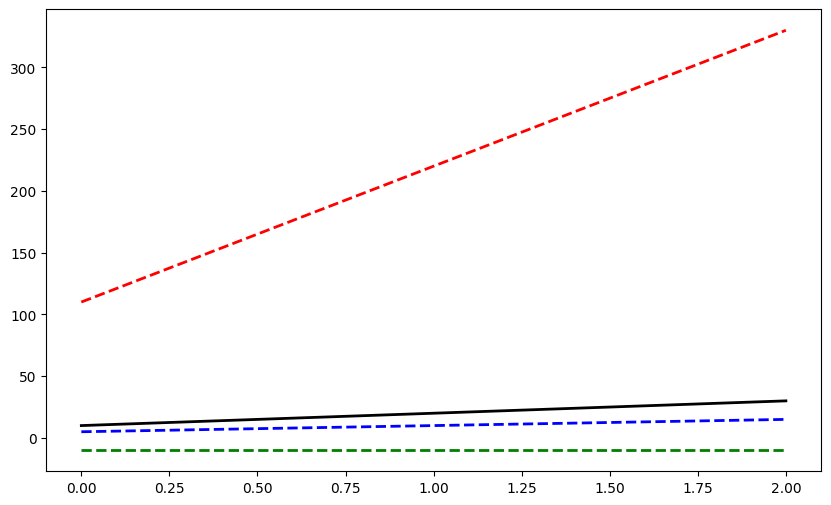

In [ ]:
# Actual values (y_actual)
y_actual = np.array([10, 20, 30])

# Forecast 1: Overestimating the actual values
y_pred_over = np.array([10+100, 20+200, 30+300])

# Forecast 2: Underestimating the actual values
y_pred_under = np.array([10-5, 20-10, 30-15])

# Forecast 3: Underestimating the actual values
y_pred_under_zero = np.array([10-20, 20-30, 30-40])

# Calculate MAPE for both scenarios
mape_over = np.mean(np.abs((y_actual - y_pred_over) / y_actual)) * 100
mape_under = np.mean(np.abs((y_actual - y_pred_under) / y_actual)) * 100
mape_under_zero = np.mean(np.abs((y_actual - y_pred_under_zero) / y_actual)) * 100

# Display results
results = pd.DataFrame({
    "Scenario": ["Overestimation", "Underestimation", "Underestimation (negative)"],
    "MAPE (%)": [mape_over, mape_under, mape_under_zero]
})
print(results)

# Visualizing the data
plt.figure(figsize=(10, 6))

# Plot actual values
plt.plot(y_actual, label="Actual Values", color="black", linewidth=2)

# Plot overestimation predictions
plt.plot(y_pred_over, label="Forecast (Overestimate)",linestyle="--", color="red", linewidth=2)

# Plot underestimation predictions
plt.plot(y_pred_under, label="Forecast (Underestimate)", linestyle="--", color="blue", linewidth=2)

# Plot negative underestimation predictions
plt.plot(y_pred_under_zero, label="Forecast (Underestimate, negative)", linestyle="--", color="green", linewidth=2)

Let's look into errors for the forecast with no regressors.

In [ ]:
print('MAPE: ', np.mean(np.abs((test['y'] - forecast['y_hat']) / test['y'])) * 100)

MAPE:  99.34577900031618


## Other errors

**MDAPE** (Median Absolute Percentage Error) is a modification of MAPE that is used to provide a more robust measure of error in cases where the data contains outliers or large deviations. The difference between MDAPE and MAPE is that MDAPE uses the median of absolute percentage errors instead of the mean.

$$\text{ Median absolute percentage error: }  MDAPE = median(\frac{|y_t - \hat{y_t}|}{y_t})$$

In [ ]:

# Пример данных
y_actual = np.array([100, 200, 300, 400, 500])  # фактические значения
y_pred = np.array([110, 210, 280, 350, 5000])    # прогнозируемые значения

# Рассчитаем MAPE
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
print("MAPE: ", mape)

# Рассчитаем MDAPE
mdape = np.median(np.abs((y_actual - y_pred) / y_actual)) * 100
print("MDAPE: ", mdape)

print("Abs diffs: " , np.abs(y_actual-y_pred))

MAPE:  186.83333333333334
MDAPE:  10.0
Abs diffs:  [  10   10   20   50 4500]


Let's look into errors for the forecast with no regressors.

In [ ]:
print('MDAPE: ', np.median(np.abs((test['y'] - forecast['y_hat']) / test['y'])) * 100)

MDAPE:  56.92668084692459


Use MDAPE when:

* Your data contains outliers or large deviations.
* You want a more stable estimate of forecast accuracy that is not highly influenced by rare but large errors.

**MASE** (Mean Absolute Scaled Error) is another error metric used in time series forecasting. It is designed to address some of the shortcomings of traditional metrics like MAPE or RMSE, particularly when comparing forecast accuracy across different time series or datasets with varying scales.

$$\text{ Mean absolute scaled error (for seasonal data): }  MASE = mean(\frac{|y_t - \hat{y_t}|}{\frac{1}{T-1}\sum^T_{t=1}|y_t-y_{t-1}|})$$

The denominator is the mean absolute error of a naive forecast, also known as the benchmark forecast. A naive forecast is one where the forecast for each time step is simply the value of the previous time step. So for time series forecasting, the naive model assumes that the forecast for time $y_t$ is the same as $y_{t-1}$. This acts as a baseline model.

Let's look into errors for the forecast with no regressors.

In [ ]:
print('MASE: ', np.mean(np.abs(test['y']-forecast['y_hat']))/np.mean(np.abs(test['y']-test['y'].shift(1))))

MASE:  2.449174179529031


MASE > 1 means that the error of the chosen forecast is larger than the error of the naive forecast, i.e., the chosen forecast is worse than the naive one. MASE < 1, on the other hand, indicates the opposite.

**SMAPE** (Symmetric Mean Absolute Percentage Error) is a metric used to evaluate the accuracy of forecast models. It is similar to MAPE, but it addresses some of the limitations of MAPE, such as issues when the actual values are close to zero.

 $$\text{ Symmetric mean absolute percentage error: }  SMAPE = mean(\frac{2*|y_t - \hat{y_t}|}{|y_t|+ |\hat{y_t}|})$$

Let's look into errors for the forecast with no regressors.

In [ ]:
print('SMAPE: ', np.mean(2*np.abs(test['y']-forecast['y_hat'])/(test['y']+forecast['y_hat'])))

SMAPE:  0.4293487893806887


## Sum up on metrics

| **Metric** | **Best Use Case** | **Advantages** | **Disadvantages** | **When to Use** |
|------------|-------------------|----------------|-------------------|-----------------|
| **MAE (Mean Absolute Error)** | When you want a simple and interpretable metric for error magnitude. | - Easy to understand and interpret.<br>- Not sensitive to outliers. | - Doesn't penalize large errors as much as RMSE. | - Suitable when you want to treat all errors equally without overemphasizing large errors. |
| **RMSE (Root Mean Squared Error)** | When you want to penalize large errors more heavily. | - Penalizes larger errors more than MAE.<br>- Commonly used in regression. | - Sensitive to outliers.<br>- Can be hard to interpret because it’s in squared units of the target variable. | - Use when large deviations from the true values are especially undesirable. |
| **MAPE (Mean Absolute Percentage Error)** | When you need percentage-based error and data doesn’t have values close to zero. | - Easy to interpret.<br>- Expressed as a percentage, making it intuitive. | - Highly sensitive to values near zero (can result in undefined or inflated values).<br>- Can overestimate errors for overestimates (Forecast > Actual). | - Use for general forecasting tasks when there are no zero values in the data, and you want to interpret errors in percentage terms. |
| **MDAPE (Median Absolute Percentage Error)** | When you want to reduce the impact of extreme outliers in the data. | - Less sensitive to outliers than MAPE.<br>- Can give a more robust measure of accuracy when the data has extreme variations. | - Doesn’t provide as clear an interpretation as MAPE, as it uses the median. | - Use when your data has outliers or is heavily skewed and you want a more robust measure. |
| **MASE (Mean Absolute Scaled Error)** | When you want to compare your model to a naive forecast. | - Allows comparison of model performance across different datasets.<br>- Normalized to a naive forecast. | - Less intuitive than MAE or RMSE.<br>- May be hard to interpret when the naive forecast is not simple. | - Use when you want to evaluate whether your model performs better than a naive model. |
| **SMAPE (Symmetric Mean Absolute Percentage Error)** | When you want a symmetric percentage-based error metric. | - Symmetric penalty for overestimation and underestimation.<br>- Better for handling errors when actual values are close to zero. | - Can behave poorly when both actual and predicted values are close to zero.<br>- Can still be difficult to interpret in some cases. | - Use when you need to treat overestimates and underestimates equally and when your data can include zero values. |


Summary:

* **MAE**: When you want an easy-to-understand metric that treats all errors equally, without penalizing large errors more.
* **RMSE**: When you need a metric that penalizes large errors more heavily and is more sensitive to outliers.
* **MAPE**: When you need percentage-based errors, but avoid it if there are zero values in your data.
* **MDAPE**: When your data contains outliers or is skewed, and you want a more robust metric than MAPE.
* **MASE**: When you want to compare your model's performance to a naive forecast, especially in cross-sectional studies. Useful for comparing models across different datasets.
* **SMAPE**: When you want a symmetric percentage-based error that is more stable than MAPE, especially when data can have zeros.

We'll be mostly using RMSE and MAPE.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MAE: ', np.mean(np.abs(test['y']-forecast['y_hat'])))
print('RMSE: ', np.sqrt(np.mean((test['y']-forecast['y_hat'])**2)))

MAE:  459365.179650879
RMSE:  511988.9519288533


🐎 Task for 10 minutes

**Evaluate your sales predictions (with regressors) with all the metrics above.**

# SUM UP

- Discussed dummy regressors (1 - for special event, 0 - otherwise) and contionous regressors (e.g. net income, oil prices)
- Used ARIMAX models for forecasting with regressors
- Learned how we can choose proper regressors for the model
- Discussed SARIMAX forecasting model which is useful for time series with seasonality
- Discussed scale-dependent, scale-independent and other quaity metrics
- Discussed how to choose proper quality metric

Please, leave your feedback [here](https://forms.gle/bh49kMtdd1driCzt6), let's make our lessons more effective :)